Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Load Weather Dataset

In [2]:
path = "srilanka_weather.csv"
df = pd.read_csv(path)


Parse Date & Time Columns

In [3]:
df["time"] = pd.to_datetime(df["time"], errors="coerce")
if "sunrise" in df.columns:
    df["sunrise"] = pd.to_datetime(df["sunrise"], errors="coerce")
if "sunset" in df.columns:
    df["sunset"] = pd.to_datetime(df["sunset"], errors="coerce")

# Sort by time (global)
df = df.sort_values("time").reset_index(drop=True)


Initial Data Inspection (EDA – Part 1)

In [4]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nDate range:")
print("Min:", df["time"].min())
print("Max:", df["time"].max())
print("\nHead:")
print(df.head())


Shape: (147480, 24)

Dtypes:
 time                          datetime64[ns]
weathercode                            int64
temperature_2m_max                   float64
temperature_2m_min                   float64
temperature_2m_mean                  float64
apparent_temperature_max             float64
apparent_temperature_min             float64
apparent_temperature_mean            float64
sunrise                       datetime64[ns]
sunset                        datetime64[ns]
shortwave_radiation_sum              float64
precipitation_sum                    float64
rain_sum                             float64
snowfall_sum                         float64
precipitation_hours                  float64
windspeed_10m_max                    float64
windgusts_10m_max                    float64
winddirection_10m_dominant             int64
et0_fao_evapotranspiration           float64
latitude                             float64
longitude                            float64
elevation                

City & Location Analysis

In [5]:
if "city" in df.columns:
    print("\nNumber of unique cities:", df["city"].nunique())
    print("\nTop 20 cities by row count:")
    print(df["city"].value_counts().head(20))

if {"latitude", "longitude"}.issubset(df.columns):
    print("\nUnique (lat,long) pairs:", df[["latitude", "longitude"]].drop_duplicates().shape[0])



Number of unique cities: 30

Top 20 cities by row count:
city
Colombo                      4916
Matale                       4916
Pothuhera                    4916
Hatton                       4916
Oruwala                      4916
Ratnapura                    4916
Kandy                        4916
Negombo                      4916
Sri Jayewardenepura Kotte    4916
Maharagama                   4916
Hambantota                   4916
Kalmunai                     4916
Trincomalee                  4916
Galle                        4916
Jaffna                       4916
Moratuwa                     4916
Athurugiriya                 4916
Mannar                       4916
Weligama                     4916
Kolonnawa                    4916
Name: count, dtype: int64

Unique (lat,long) pairs: 23


Missing Values 

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct})
print("\nMissing values (non-zero only):")
print(missing_table[missing_table["missing_count"] > 0].head(30))



Missing values (non-zero only):
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


Duplicate Check

In [7]:
print("\nDuplicate rows:", df.duplicated().sum())
if "city" in df.columns:
    print("Duplicate (city, time) rows:", df.duplicated(subset=["city", "time"]).sum())



Duplicate rows: 0
Duplicate (city, time) rows: 0


Time Frequency Analysis

In [8]:
if "city" in df.columns:
    freq_summary = []
    for city, g in df.groupby("city"):
        g = g.sort_values("time")
        diffs = g["time"].diff().dropna()
        if len(diffs) == 0:
            continue
        most_common = diffs.value_counts().idxmax()
        freq_summary.append((city, len(g), most_common))

    freq_df = pd.DataFrame(freq_summary, columns=["city", "rows", "most_common_time_gap"])
    print("\nMost common time gap per city (top 20 rows):")
    print(freq_df.sort_values("rows", ascending=False).head(20))
else:
    diffs = df["time"].diff().dropna()
    print("\nMost common time gap:", diffs.value_counts().idxmax())



Most common time gap per city (top 20 rows):
                         city  rows most_common_time_gap
0                Athurugiriya  4916               1 days
1                     Badulla  4916               1 days
28                Trincomalee  4916               1 days
27  Sri Jayewardenepura Kotte  4916               1 days
26                  Ratnapura  4916               1 days
25                   Puttalam  4916               1 days
24                  Pothuhera  4916               1 days
23                    Oruwala  4916               1 days
22                    Negombo  4916               1 days
21              Mount Lavinia  4916               1 days
20                   Moratuwa  4916               1 days
19                     Matara  4916               1 days
18                     Matale  4916               1 days
17                     Mannar  4916               1 days
16                 Maharagama  4916               1 days
15                     Mabole  4916       

Rainfall Exploratory Analysis

    Rain Distribution (≥ 0.1mm – Drizzle Threshold)


Rain column statistics:
count    147480.000000
mean          5.975637
std          10.215294
min           0.000000
25%           0.400000
50%           2.600000
75%           7.500000
max         338.800000
Name: precipitation_sum, dtype: float64

Rain today (>=0.1mm) distribution:
rain_today_0p1
1    120753
0     26727
Name: count, dtype: int64
rain_today_0p1
1    81.88
0    18.12
Name: proportion, dtype: float64


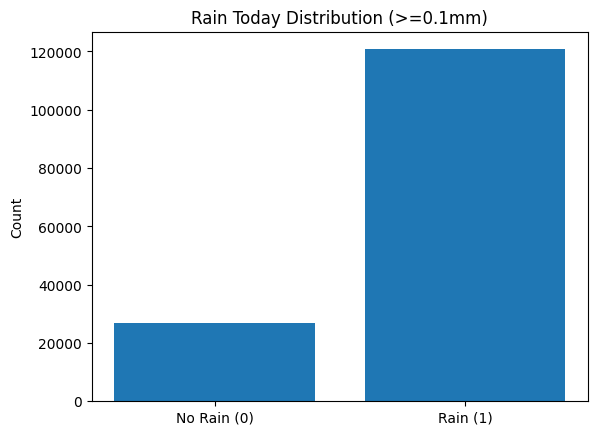

In [9]:
rain_col = "precipitation_sum"   

print("\nRain column statistics:")
print(df[rain_col].describe())

df["rain_today_0p1"] = (df[rain_col].fillna(0) >= 0.1).astype(int)
print("\nRain today (>=0.1mm) distribution:")
print(df["rain_today_0p1"].value_counts())
print((df["rain_today_0p1"].value_counts(normalize=True) * 100).round(2))

counts = df["rain_today_0p1"].value_counts().sort_index()
plt.figure()
plt.bar(["No Rain (0)", "Rain (1)"], counts.values)
plt.title("Rain Today Distribution (>=0.1mm)")
plt.ylabel("Count")
plt.show()


Rain Distribution (≥ 2.0mm – Classification Threshold)


Rain today (>=2.0mm) distribution:
rain_today
1    82197
0    65283
Name: count, dtype: int64
rain_today
1    55.73
0    44.27
Name: proportion, dtype: float64


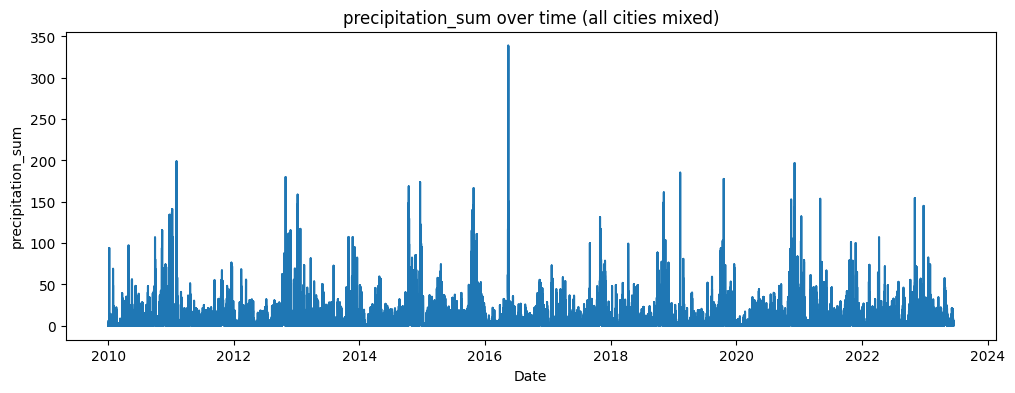

In [10]:
#Better threshold for classification target (2.0mm)
threshold = 2.0
df["rain_today"] = (df[rain_col].fillna(0) >= threshold).astype(int)
print("\nRain today (>=2.0mm) distribution:")
print(df["rain_today"].value_counts())
print((df["rain_today"].value_counts(normalize=True) * 100).round(2))

# Plot precipitation over time 
plt.figure(figsize=(12,4))
plt.plot(df["time"], df[rain_col])
plt.title(f"{rain_col} over time (all cities mixed)")
plt.xlabel("Date")
plt.ylabel(rain_col)
plt.show()


City-Level Rainfall Visualization

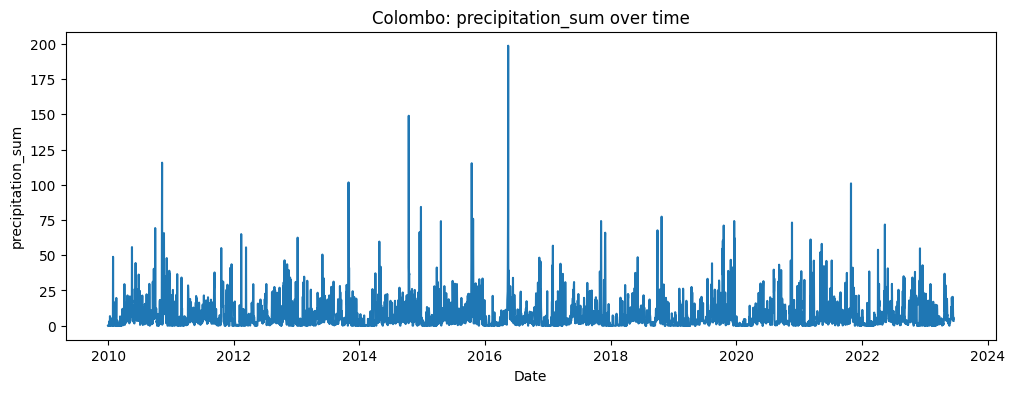

In [11]:
#single city plot
city_name = "Colombo"
df_city = df[df["city"] == city_name].sort_values("time").reset_index(drop=True)
plt.figure(figsize=(12,4))
plt.plot(df_city["time"], df_city[rain_col])
plt.title(f"{city_name}: {rain_col} over time")
plt.xlabel("Date")
plt.ylabel(rain_col)
plt.show()


Target Variable Creation

In [12]:
# Sort properly before shift
df = df.sort_values(["city", "time"]).reset_index(drop=True)

df["rain_tomorrow"] = df.groupby("city")["rain_today"].shift(-1)
df = df.dropna(subset=["rain_tomorrow"]).copy()
df["rain_tomorrow"] = df["rain_tomorrow"].astype(int)

print("\nAfter creating target:")
print("Shape:", df.shape)
print("Target distribution (%):")
print((df["rain_tomorrow"].value_counts(normalize=True) * 100).round(2))



After creating target:
Shape: (147450, 27)
Target distribution (%):
rain_tomorrow
1    55.75
0    44.25
Name: proportion, dtype: float64


Correlation & Leakage Analysis

In [13]:
corr = df.corr(numeric_only=True)["rain_tomorrow"].sort_values(ascending=False)
print("\nTop positive correlations with rain_tomorrow:")
print(corr.head(15))
print("\nTop negative correlations with rain_tomorrow:")
print(corr.tail(15))



Top positive correlations with rain_tomorrow:
rain_tomorrow                 1.000000
precipitation_hours           0.578557
rain_today                    0.550401
weathercode                   0.499422
rain_today_0p1                0.442359
precipitation_sum             0.350467
rain_sum                      0.350467
winddirection_10m_dominant    0.170354
apparent_temperature_min      0.157670
windgusts_10m_max             0.046118
temperature_2m_min            0.045880
apparent_temperature_mean     0.034554
elevation                    -0.006676
apparent_temperature_max     -0.073284
windspeed_10m_max            -0.082359
Name: rain_tomorrow, dtype: float64

Top negative correlations with rain_tomorrow:
winddirection_10m_dominant    0.170354
apparent_temperature_min      0.157670
windgusts_10m_max             0.046118
temperature_2m_min            0.045880
apparent_temperature_mean     0.034554
elevation                    -0.006676
apparent_temperature_max     -0.073284
windspeed_10

Feature Selection (Removing Leakage Columns)

In [14]:
leak_cols = [
    "precipitation_sum",
    "rain_sum",
    "precipitation_hours",
    "rain_today",
    "weathercode",      
    "snowfall_sum"
]
df = df.drop(columns=leak_cols, errors="ignore")


Time-Based Feature Engineering

In [15]:
df["month"] = df["time"].dt.month
df["day_of_year"] = df["time"].dt.dayofyear
df["year"] = df["time"].dt.year



Chronological Train-Test Split

In [16]:
df = df.sort_values("time").reset_index(drop=True)

unique_dates = df["time"].unique()
split_index = int(len(unique_dates) * 0.8)

train_dates = unique_dates[:split_index]
test_dates  = unique_dates[split_index:]

train_df = df[df["time"].isin(train_dates)].copy()
test_df  = df[df["time"].isin(test_dates)].copy()

print("\nTrain shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train date range:", train_df["time"].min(), "to", train_df["time"].max())
print("Test date range:", test_df["time"].min(), "to", test_df["time"].max())



Train shape: (117960, 24)
Test shape: (29490, 24)
Train date range: 2010-01-01 00:00:00 to 2020-10-06 00:00:00
Test date range: 2020-10-07 00:00:00 to 2023-06-16 00:00:00


One-Hot Encoding

In [17]:
train_df = pd.get_dummies(train_df, columns=["city"], drop_first=True)
test_df  = pd.get_dummies(test_df,  columns=["city"], drop_first=True)

train_df, test_df = train_df.align(test_df, join="left", axis=1, fill_value=0)


Removing Non-Numeric and Irrelevant Features

In [18]:
drop_cols = ["time", "sunrise", "sunset", "country"]
train_df = train_df.drop(columns=drop_cols, errors="ignore")
test_df  = test_df.drop(columns=drop_cols, errors="ignore")


Feature–Target Separation (X and y Preparation)

In [19]:
X_train = train_df.drop(columns=["rain_tomorrow"])
y_train = train_df["rain_tomorrow"].astype(int)

X_test = test_df.drop(columns=["rain_tomorrow"])
y_test = test_df["rain_tomorrow"].astype(int)

print("\nX_train:", X_train.shape, "X_test:", X_test.shape)
print("Train target %:", (y_train.value_counts(normalize=True) * 100).round(2).to_dict())
print("Test target %:",  (y_test.value_counts(normalize=True) * 100).round(2).to_dict())



X_train: (117960, 47) X_test: (29490, 47)
Train target %: {1: 55.32, 0: 44.68}
Test target %: {1: 57.45, 0: 42.55}


Chronological Validation Strategy

In [20]:
# Create train/val split from train_df (chronological) 
train_df2 = train_df.copy() 

Baseline Model Training – XGBoost Classifier

In [21]:
from xgboost import XGBClassifier

baseline_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"
)

baseline_model.fit(X_train, y_train)

y_pred_base = baseline_model.predict(X_test)
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]

Baseline Performance Evaluation

In [22]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("Baseline Accuracy :", accuracy_score(y_test, y_pred_base))
print("Baseline F1       :", f1_score(y_test, y_pred_base))
print("Baseline ROC-AUC  :", roc_auc_score(y_test, y_prob_base))

Baseline Accuracy : 0.7126483553747033
Baseline F1       : 0.726962237401727
Baseline ROC-AUC  : 0.7942014928784256


Hyperparameter Tuning – XGBoost

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# Time series CV
tscv = TimeSeriesSplit(n_splits=5)

# Base model
xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"  
)

param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.5, 1, 2],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 2, 5, 10]
}

# Use F1 as tuning objective 
f1_scorer = make_scorer(f1_score)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,              
    scoring=f1_scorer,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best Params:\n", search.best_params_)
print("Best CV F1:", search.best_score_)
best_model = search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params:
 {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV F1: 0.8073344351255809


Tuned Model Evaluation

In [24]:
best_model = search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("Tuned Accuracy :", accuracy_score(y_test, y_pred_tuned))
print("Tuned F1       :", f1_score(y_test, y_pred_tuned))
print("Tuned ROC-AUC  :", roc_auc_score(y_test, y_prob_tuned))

Tuned Accuracy : 0.74774499830451
Tuned F1       : 0.7797352915050484
Tuned ROC-AUC  : 0.8242516959933653


SHAP Explainability Analysis for Tuned Model (Single Sample)

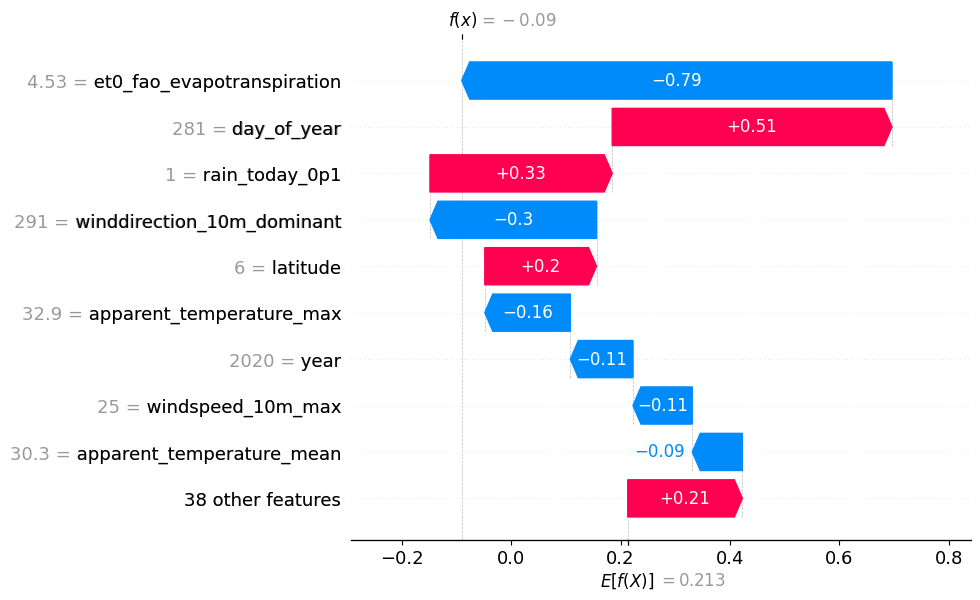

In [25]:
import shap
import numpy as np

# Use the tuned model 
explainer = shap.TreeExplainer(best_model)

i = 0 
x_one = X_test.iloc[[i]]

# SHAP values for one sample
shap_values_one = explainer(x_one)

shap.plots.waterfall(shap_values_one[0])

SHAP Feature Dependence Analysis

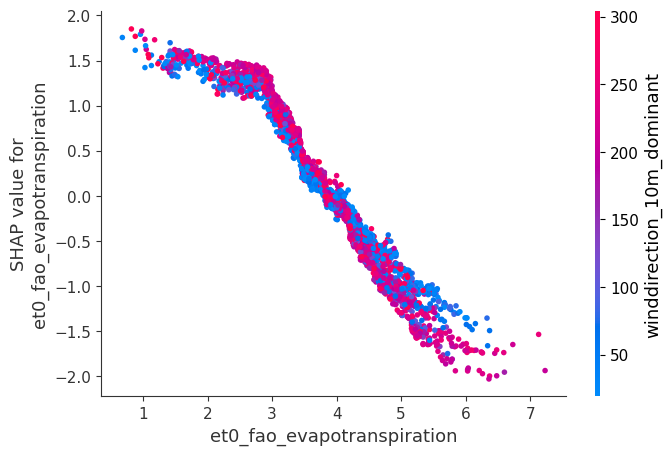

In [26]:
# Use a sample for speed 
X_sample = X_test.sample(3000, random_state=42)

shap_values = explainer.shap_values(X_sample)

shap.dependence_plot("et0_fao_evapotranspiration", shap_values, X_sample)

SHAP Dependence Plots for Selected Features

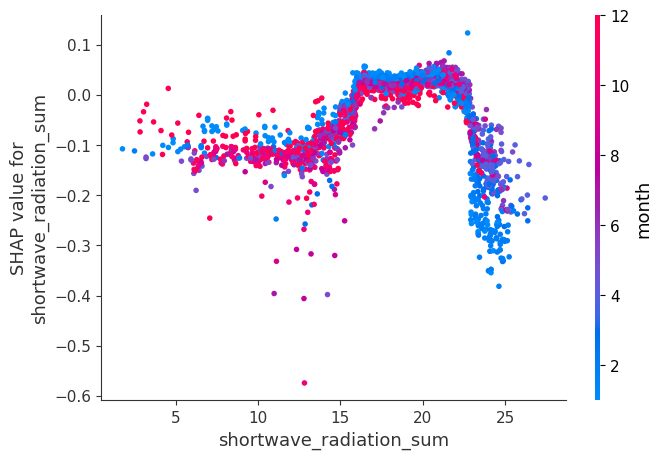

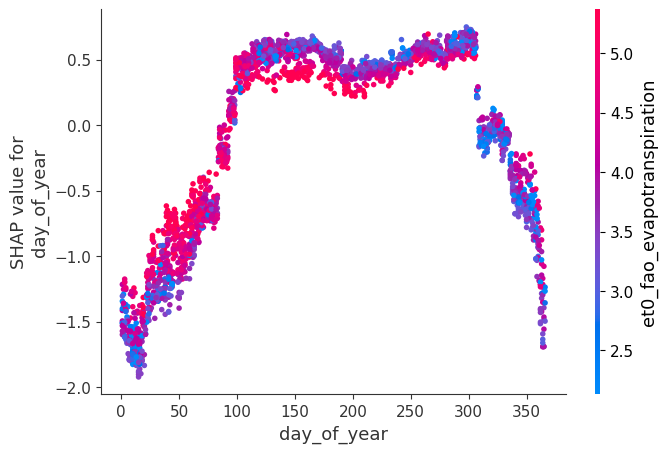

In [27]:
shap.dependence_plot("shortwave_radiation_sum", shap_values, X_sample)
shap.dependence_plot("day_of_year", shap_values, X_sample)

Decision Threshold Optimization for F1-Score

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

probs = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
best_t, best_f1 = None, -1

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold for F1:", best_t)
print("Best F1:", best_f1)

# show precision
preds_best = (probs >= best_t).astype(int)
print("Precision:", precision_score(y_test, preds_best))
print("Recall   :", recall_score(y_test, preds_best))

Best threshold for F1: 0.30000000000000004
Best F1: 0.8021712907117008
Precision: 0.721768675381058
Recall   : 0.9027326919671841


Saving Model Artifact and Booster for Deployment

In [29]:
import pickle

THRESHOLD = 0.30

# small background sample for KernelExplainer
background = X_train.sample(200, random_state=42)
background = X_train.sample(200, random_state=42).copy()
background = background.apply(pd.to_numeric, errors="coerce").fillna(0.0)

artifact = {
    "threshold": THRESHOLD,
    "feature_columns": list(X_train.columns),
    "background": background
}

with open("rain_artifact_meta.pkl", "wb") as f:
    pickle.dump(artifact, f)

best_model.get_booster().save_model("xgb_booster.json")
print("Saved xgb_booster.json + rain_artifact_meta.pkl (with background)")

Saved xgb_booster.json + rain_artifact_meta.pkl (with background)
